# Classifying buildings Post Hurricane using Satellite Imagery
The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we ask you to classify buildings between damaged and not damaged buildings using the satellite imagery data provided to you. 

The data is provided to you has the following subfolders:

* train_another: the training data; 5000 images of each class(damage/no damage)
* validation_another: the validation data; 1000 images of each class(damage/no damage)
* test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes
* test: the balanced test data; 1000 images of each class(damage/no damage)

The dataset is collected from "Geo-satellite sensor" and "Geo Bigdata". 
To give you an example of the data you will be dealing with:

The first image is before the hurricane hit the "no damage" class and the second after the hurricane hit "damaged" class. You can see in the second image, the building is surrounded by water. But what you can also notice is the clarity of these images. So you get the point! It's time to show your preprocessing skills! 

To test your model further you can use the data collected from Hurricane Delta - Note this is satellite imagery as well, but the images are not specifically of buildings but also of water bodies and land, so choose your testing images wisely.

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import random
import cv2
from glob2 import glob
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread as imread
from skimage.util import montage
from PIL import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNet
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Let's do some image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rotation_range=180, 
                                   width_shift_range=2,
                                   height_shift_range=2, 
                                   brightness_range=[0.8,1.5],
                                   zoom_range=[0.5,2.0])
test_datagen = ImageDataGenerator(rescale=1./255)

## The data is provided to you has the following subfolders:

* train_another: the training data; 5000 images of each class(damage/no damage)

* validation_another: the validation data; 1000 images of each class(damage/no damage)

* test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes

* test: the balanced test data; 1000 images of each class(damage/no damage)

In [ ]:
#Let's load our entire dataset in train, test and validation set as mentioned above
train_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/train_another',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 shuffle = True,
                                                 class_mode='binary')
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/test',
                                                 target_size=(224,224),
                                                 shuffle = True,batch_size=1000,
                                                 class_mode='binary')
test_another_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/test_another',
                                                 target_size=(224,224),
                                                 shuffle = True,batch_size=1000,
                                                 class_mode='binary')
validation_another_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/validation_another',
                                                 target_size=(224,224),
                                                 batch_size=32,shuffle = True,
                                                 class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
#Let's check how data is mapped before proceeding
print("\n",train_set.class_indices,"\n",test_set.class_indices,"\n",test_another_set.class_indices,"\n",validation_another_set.class_indices)


 {'damage': 0, 'no_damage': 1} 
 {'damage': 0, 'no_damage': 1} 
 {'damage': 0, 'no_damage': 1} 
 {'damage': 0, 'no_damage': 1}


* We are going to use a VGG 16 model as our first model where we will freeze all the layers at first to see how much accurate it is on our dataset.

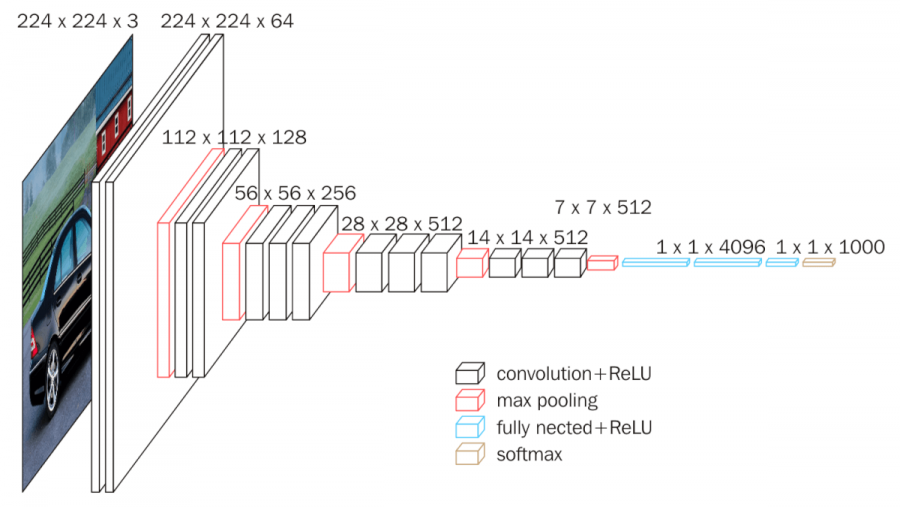

[More about VGG 16 is here](https://neurohive.io/en/popular-networks/vgg16/)

In [ ]:
# Let's load a VGG-16 Architecture
input_shape = [224,224,3]
VGG_16 = VGG16(input_shape= input_shape ,weights='imagenet',include_top=False)

* The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. No tilde expansion is done, but *, ?, and character ranges expressed with [ ] will be correctly matched.

>>> glob.glob(pathname, *, root_dir=None, dir_fd=None, recursive=False)

In [ ]:
folders = glob('../content/gdrive/MyDrive/archive/train_another/*')

Layers & models also feature a boolean attribute trainable. Its value can be changed.
>>> layer.trainable = False

By doing this we are moving all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training. Here, we are not going to retrain it over the entire data for our first model.

Later We will explore the time it takes for training and how much it affects the model accuracy.

In [ ]:
#Freezing the layers
for layer in VGG_16.layers:
    layer.trainable = False

In [ ]:
# X = Flatten()(VGG_16.output)
X= GlobalAveragePooling2D()(VGG_16.output)
output = Dense(len(folders),activation='softmax')(X)
model = Model(inputs= VGG_16.input,outputs=output)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_set,
                    validation_data=validation_another_set,
                    epochs=15,
                    steps_per_epoch=100,
                    validation_steps=30,
                    verbose=1)

Epoch 1/30
100/100 [==============================] - 75s 746ms/step - loss: 0.6108 - accuracy: 0.7019 - val_loss: 0.5479 - val_accuracy: 0.7271
Epoch 2/30
100/100 [==============================] - 108s 1s/step - loss: 0.5321 - accuracy: 0.7634 - val_loss: 0.4782 - val_accuracy: 0.7990
Epoch 3/30
100/100 [==============================] - 71s 714ms/step - loss: 0.4970 - accuracy: 0.7809 - val_loss: 0.4377 - val_accuracy: 0.8260
Epoch 4/30
100/100 [==============================] - 69s 685ms/step - loss: 0.4780 - accuracy: 0.7884 - val_loss: 0.4062 - val_accuracy: 0.8500
Epoch 5/30
100/100 [==============================] - 70s 695ms/step - loss: 0.4572 - accuracy: 0.8003 - val_loss: 0.3814 - val_accuracy: 0.8635
Epoch 6/30
100/100 [==============================] - 68s 678ms/step - loss: 0.4563 - accuracy: 0.7999 - val_loss: 0.3649 - val_accuracy: 0.8687
Epoch 7/30
100/100 [==============================] - 68s 679ms/step - loss: 0.4476 - accuracy: 0.8037 - val_loss: 0.4039 - val_accu

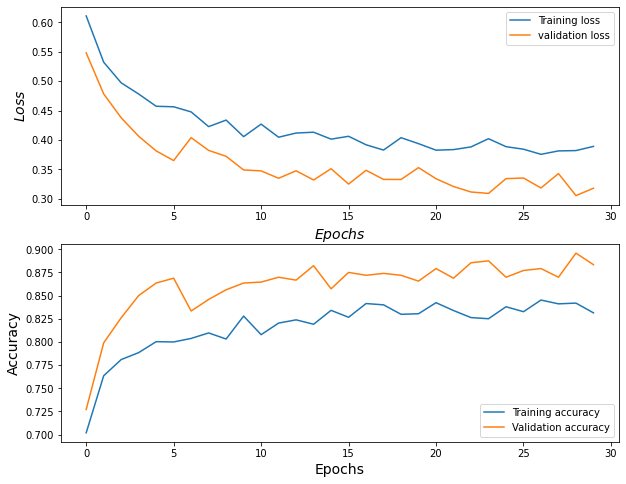

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].set_xlabel('$Epochs$',fontsize=14)
ax[0].set_ylabel('$Loss$',fontsize=14)
ax[0].plot(history.history['loss'],  label="Training loss")
ax[0].plot(history.history['val_loss'],  label="validation loss")
legend = ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'],  label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_ylabel('Accuracy',fontsize=14)
legend = ax[1].legend(loc='best')

In [ ]:
# Test Accuracy on Test set
Accuracy = model.evaluate(test_set,steps=100)
print('The testing accuracy is :',Accuracy[1]*100, '%')

100/100 [==============================] - 355s 4s/step - loss: 0.3289 - accuracy: 0.8775
The testing accuracy is : 87.74999976158142 %


In [ ]:
# Test Accuracy on Another Test set
Accuracy_another = model.evaluate(test_another_set,steps=100)
print('The testing accuracy is :',Accuracy_another[1]*100, '%')

100/100 [==============================] - 685s 7s/step - loss: 0.3728 - accuracy: 0.8781
The testing accuracy is : 87.8125011920929 %


In [ ]:
Accuracy_another_1 = model.evaluate(test_another_set,steps=1)
print('The testing accuracy is :',Accuracy_another_1[1]*100, '%')

1/1 [==============================] - 0s 413ms/step - loss: 0.2902 - accuracy: 0.9375
The testing accuracy is : 93.75 %


In [ ]:
# Let's save our model
model.save('Hurricane_Classifier_1.h5')

In [ ]:
#Let's load our model
model_1 = load_model("Hurricane_Classifier_1.h5")

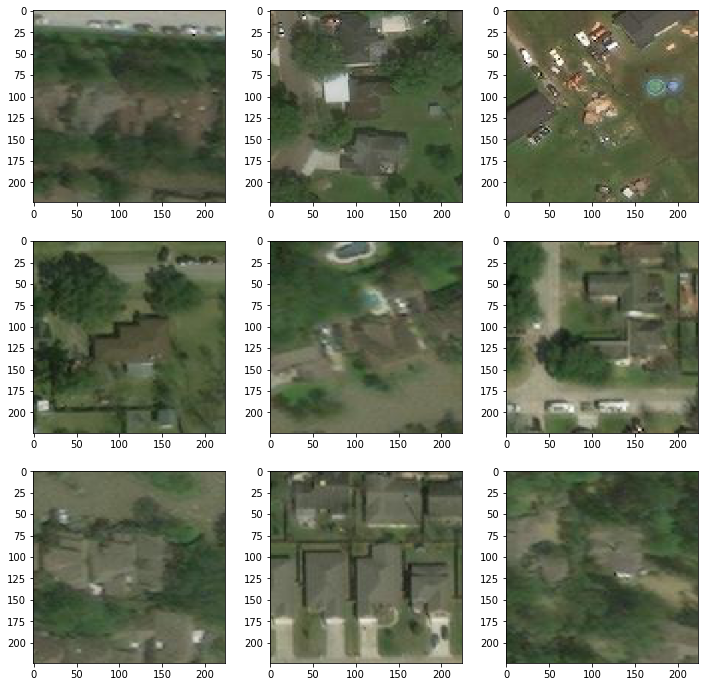

In [ ]:
#let's see how it does in terms of classification
x,y = test_set.next()
fig=plt.figure(figsize=(12,12))
for i in range(9):
  ax=fig.add_subplot(3,3,i+1)
  ax.imshow(x[i])
plt.show()

## Let's test by intentionally picking a Hurricane affected and non-affected building image from test_another_set

### Hurricane affected from test_another_set

No Damage


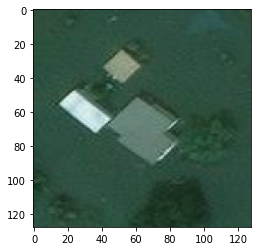

In [ ]:
plt.imshow(cv2.imread('/content/gdrive/MyDrive/archive/test_another/damage/-93.55919200000001_30.98323.jpeg'))
img = image.load_img('/content/gdrive/MyDrive/archive/test_another/damage/-93.55919200000001_30.98323.jpeg',target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
pred = classes.argmax()
if pred == 1:print("No Damage")
else:print("Damaged by Hurricane")

### Not affected from Hurricane from test_another_set

Not Damaged by hurricane


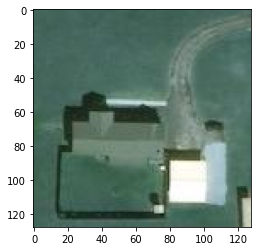

In [ ]:
# Hurricane affected from test_another_set
plt.imshow(cv2.imread('/content/gdrive/MyDrive/archive/test_another/no_damage/-95.062321_30.060401000000002.jpeg'))
img = image.load_img('/content/gdrive/MyDrive/archive/test_another/no_damage/-95.062321_30.060401000000002.jpeg',target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
pred = classes.argmax()
if pred == 1:print("Not Damaged by hurricane")
else:print("Damaged by Hurricane")

## Saliency Mapping
n computer vision, a saliency map is an image that highlights the region on which people's eyes focus first. : Source - Wikipedia

A saliency map is a way to measure the spatial support of a particular class in each image. It is the oldest and most frequently used explanation method for interpreting the predictions of convolutional neural networks. The saliency map is built using gradients of the output over the input.

>>>[More on saliency Mapping](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjn66Wctuj0AhWiheYKHdKsB0kQFnoECAUQAw&url=https%3A%2F%2Ftowardsdatascience.com%2Fpractical-guide-for-visualizing-cnns-using-saliency-maps-4d1c2e13aeca&usg=AOvVaw0sEB2MrxDRCydtJcQp0iKS)

In [ ]:
# Get the name of the last convolution layer
conv_layer_name = model.layers[-4].name
print(conv_layer_name)

block5_conv3


In [ ]:
# Taking a sample image from Non Damaged class to find the saliency map
img_path = '/content/gdrive/MyDrive/archive/test_another/no_damage/-95.062321_30.060401000000002.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
# Converting the image to a numpy array 
x = image.img_to_array(img)
# Add an extra dimension for batch size to change it to (1,224,224,3)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
# Let's be sure that we got what we were looking for
x.shape

(1, 224, 224, 3)

In [ ]:
last_conv_layer = model.get_layer(conv_layer_name)
# Get the output predictions and the last_conv_layer
# Using tf.keras functional API
get_maps = Model(inputs = [model.inputs], outputs = [model.output, last_conv_layer.output])

### Now we are going to perform the Grad-CA by taking the gradient of the output with respect to the feature maps after the convolution 

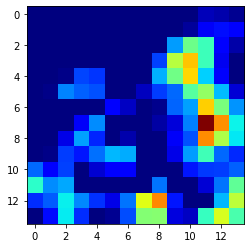

In [ ]:
with tf.GradientTape() as tape:

    # Getting the required outputs 
    model_out, last_conv_layer = get_maps(x)
    
    # We choose the output with maximum probability (choice basis)
    class_out = tf.reduce_max(model_out)

# We take the gradients 
# tape.gradient() takes the gradient of something with respect to 
# something else. Here we want the derivative of the output class
# with respect to to the last conv layer
grads = tape.gradient(class_out,last_conv_layer)
# Here we combine all the gradients for each feature map 
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  
# As per grad-CAM literature, here we need to multiply 
# the pooled grads with each feature map and take the average across
# all the feature maps to make the heat map
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) 
# Below we convert heatmap to numpy
# Make all values positive
# and reshape from (1,14,14) to (14,14) for ease of plotting
heatmap = heatmap.numpy()
heatmap[heatmap < 0] = 0 #relu
heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
heatmap = heatmap.reshape((14,14))


plt.imshow(heatmap,cmap='jet')
plt.show()

In [ ]:
# Inorder to map to the original image This heatmap has to be be resized
resized_heatmap = np.uint8(cv2.resize(heatmap,(224,224))*255)
# We need to add a pre-processing step
# to convert the grayscale heatmap
# to a true JET colormap of 3 channels
# for ease of viewing
val = np.uint8(256-resized_heatmap)
heatmap_final = cv2.applyColorMap(val, cv2.COLORMAP_JET)
# We also prepare the image for plotting
# by converting to tensor
# and converting dtype to int8
img = image.img_to_array(img)
img = np.uint8(img)

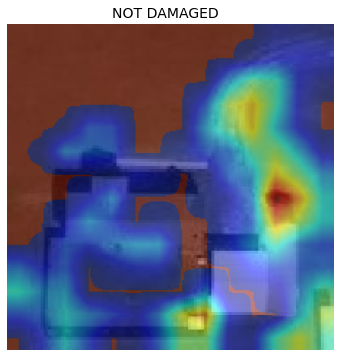

In [ ]:
# Finally, we use the cv2.addweighted function
# to superimpose the heatmap on the original image
# Use the helper code below to do the same
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(cv2.addWeighted(heatmap_final, 0.5, img, 0.5, 0))
ax.axis('off');
fig.suptitle('NOT DAMAGED',y=0.92,fontsize=14);
plt.show();

### Let's se how the saliency mapping works for Damaged class and what it is looking for!!!

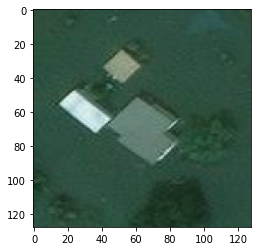

In [ ]:
img_path = '/content/gdrive/MyDrive/archive/test_another/damage/-93.55919200000001_30.98323.jpeg'
plt.imshow(cv2.imread(img_path))

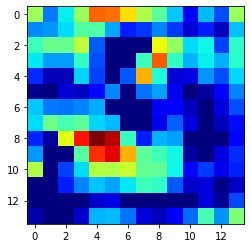

In [ ]:
# Taking a sample image from Damaged class to find the saliency map
last_conv_layer = model.get_layer(conv_layer_name)
get_maps = Model(inputs = [model.inputs], outputs = [model.output, last_conv_layer.output])
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
with tf.GradientTape() as tape:
    model_out, last_conv_layer = get_maps(x)
    class_out = tf.reduce_max(model_out)

grads = tape.gradient(class_out,last_conv_layer)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) 
heatmap = heatmap.numpy()
heatmap[heatmap < 0] = 0 #relu
heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
heatmap = heatmap.reshape((14,14))

plt.imshow(heatmap,cmap='jet')
plt.show()

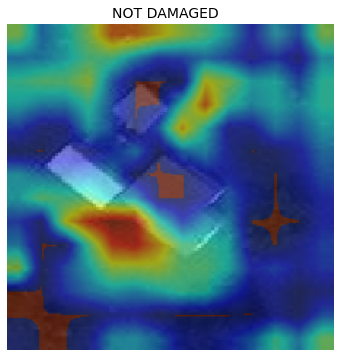

In [ ]:
resized_heatmap = np.uint8(cv2.resize(heatmap,(224,224))*255)
val = np.uint8(256-resized_heatmap)
heatmap_final = cv2.applyColorMap(val, cv2.COLORMAP_JET)
img = image.img_to_array(img)
img = np.uint8(img)
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(cv2.addWeighted(heatmap_final, 0.5, img, 0.5, 0))
ax.axis('off');
fig.suptitle('NOT DAMAGED',y=0.92,fontsize=14);
plt.show();

In [ ]:
test_another_set.class_indices

{'damage': 0, 'no_damage': 1}

## Predicting it on the random images from test_set and Test_another_set

In [ ]:
# let's make a custom dictionary to map damage and no_damage with 0 and 1 respectively
dict_1 = { 0 :'damage', 1: 'no_damage'}

In [ ]:
x,y = test_another_set.next()
x.shape

(100, 224, 224, 3)

## Predicting on Test_another_set

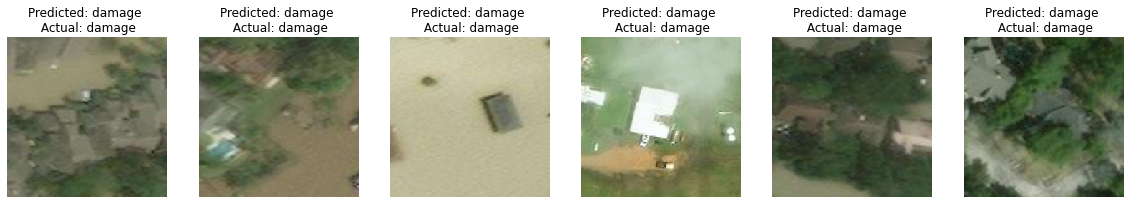

In [ ]:
x,y = test_another_set.next()
fig, ax = plt.subplots(1,6,figsize=(20,20))
for i in range(6):
    image_index = random.randint(1,1000)
    prediction= dict_1[int(np.squeeze(np.argmax(model.predict(x[image_index:image_index+1]),axis=1),axis=0))]
    img = (x[image_index])
    ax[i].imshow(img)
    ax[i].set_title(f'Predicted: {prediction} \n Actual: {dict_1[np.argmax(y[image_index])]}')
    ax[i].axis('off')

In [ ]:
x.shape

(1000, 224, 224, 3)

### Now we will explore other models, even we will look at how weight training over layes of VGG 16 affects the output

In [ ]:
# Please download the 2.1.0 version of tensorflow for this homework and also tf_keras_vis
!pip3 -qq install tf_keras_vis 
!pip -qq install tensorflow==2.1.0
!pip -qq install tensorflow_addons==0.9.1

     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 421.8 MB 27 kB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 3.8 MB 36.0 MB/s 
     |████████████████████████████████| 448 kB 30.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 1.0 MB 4.9 MB/s 


In [ ]:
import os
import gdown

if os.path.isdir('/content/gdrive/MyDrive/archive/train_another'):
    print('Found dataset' )
else:
    os.makedirs('/content/gdrive/MyDrive/archive')
    !gdown -qq https://drive.google.com/u/0/uc?id=1EH3p84xKMs_2m4ISSR7aHOQz61yxIv8L&export=download
    !unzip Post-hurricane.zip  -d /content/drive/MyDrive/Univ.AI/AI-02/Project/Post-hurricane

Found dataset


In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l1, l2 
import cv2

In [ ]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from sklearn.metrics import confusion_matrix

In [ ]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.7.0
keras version 2.7.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
train_datagen=ImageDataGenerator()

train_generator=train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/train_another',batch_size=64, class_mode='binary', shuffle=True)
validation_generator=train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/validation_another',batch_size=64, class_mode='binary', shuffle=True)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Text(0.5, 1.0, '1.0')

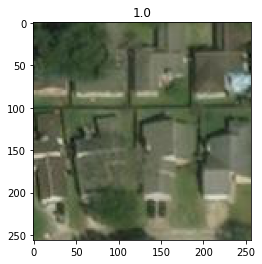

In [ ]:
data = train_generator.next()
img = data[0]
label = data[1]
plt.imshow(np.array(img[10],np.int32))
plt.title(str(label[10]))

In [ ]:
model = Sequential(name="Custom_Model")
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), kernel_regularizer = l2()))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = l2()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = l2()))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = l2()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer = l2()))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer = l2()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer = l2()))
model.add(Dense(128, activation='relu', kernel_regularizer = l2()))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 252, 252, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)     

In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=step_size_train, validation_steps=step_size_validation, epochs=20)


Train for 156 steps, validate for 31 steps
Epoch 1/20
156/156 [==============================] - 119s 762ms/step - loss: 10.7779 - accuracy: 0.8360 - val_loss: 7.5465 - val_accuracy: 0.5318
Epoch 2/20
156/156 [==============================] - 118s 757ms/step - loss: 4.5372 - accuracy: 0.9156 - val_loss: 6.3813 - val_accuracy: 0.5857
Epoch 3/20
156/156 [==============================] - 118s 755ms/step - loss: 3.0287 - accuracy: 0.9328 - val_loss: 2.7825 - val_accuracy: 0.6820
Epoch 4/20
156/156 [==============================] - 116s 747ms/step - loss: 2.0073 - accuracy: 0.9415 - val_loss: 4.7987 - val_accuracy: 0.5675
Epoch 5/20
156/156 [==============================] - 116s 743ms/step - loss: 1.5961 - accuracy: 0.9421 - val_loss: 2.1863 - val_accuracy: 0.5302
Epoch 6/20
156/156 [==============================] - 116s 746ms/step - loss: 1.1752 - accuracy: 0.9462 - val_loss: 1.6480 - val_accuracy: 0.8448
Epoch 7/20
156/156 [==============================] - 116s 747ms/step - loss: 0

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/final_model')
model.save('/content/drive/MyDrive/overall_model.h5')


In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

### We already saved the model weights as it takes "forever" to redo it!

In [ ]:
path = "/content/gdrive/MyDrive/overall_model.h5"
model = tf.keras.models.load_model(path)

In [ ]:
test_balanced_generator=train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/test',batch_size=64, class_mode='binary', shuffle=True)
model.evaluate(test_balanced_generator)

Found 2000 images belonging to 2 classes.
32/32 [==============================] - 13s 271ms/step - loss: 0.3787 - accuracy: 0.9470


[0.37870073318481445, 0.9470000267028809]

In [ ]:
test_imbalanced_generator=train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/test_another',batch_size=64, class_mode='binary', shuffle=True)
model.evaluate(test_imbalanced_generator)


Found 9000 images belonging to 2 classes.
141/141 [==============================] - 41s 293ms/step - loss: 0.4178 - accuracy: 0.9508


[0.417759507894516, 0.9507777690887451]

In [ ]:
y_init=np.array([])
y_pred=np.array([])
test_balanced_generator=train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/test',batch_size=64, class_mode='binary', shuffle=True)
for i in range(int(test_balanced_generator.n/64)+1):
  x, y = next(test_balanced_generator)
  y_temp = model.predict(x)
  y_pred = np.append(y_pred, y_temp)
  y_init = np.append(y_init, y)

Found 2000 images belonging to 2 classes.


* We need to look at the confusion matrix to see if what we are seeing as a prediction is actually acceptable.

In [ ]:
y_pred  = list(map(lambda x: 0 if x<0.5 else 1, y_pred ))
confusion_matrix(y_pred, y_init)

array([[949,  55],
       [ 51, 945]])

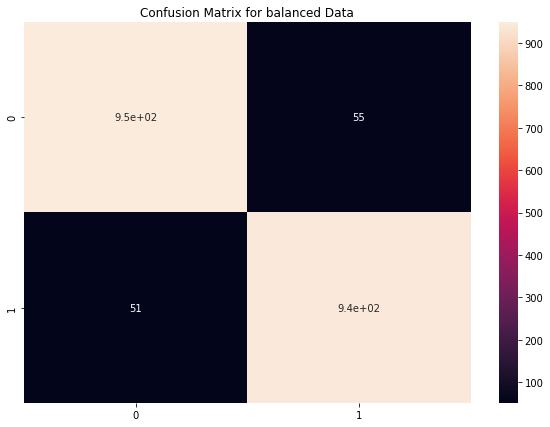

In [ ]:
plt.figure(figsize=(10,7))

sns.heatmap(confusion_matrix(y_pred, y_init), annot=True) # font size
plt.title("Confusion Matrix for balanced Data")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report for balanced Data : \n")
print(classification_report(y_pred, y_init))

Classification Report for balanced Data : 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1004
           1       0.94      0.95      0.95       996

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
y_init=np.array([])
y_pred=np.array([])
test_imbalanced_generator=train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/test_another',batch_size=64, class_mode='binary', shuffle=True)
for i in range(int(test_imbalanced_generator.n/64)+1):
  x, y = next(test_imbalanced_generator)
  y_temp = model.predict(x)
  y_pred = np.append(y_pred, y_temp)
  y_init = np.append(y_init, y)

Found 9000 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred  = list(map(lambda x: 0 if x<0.5 else 1, y_pred ))
confusion_matrix(y_pred, y_init)

array([[7614,   57],
       [ 386,  943]])

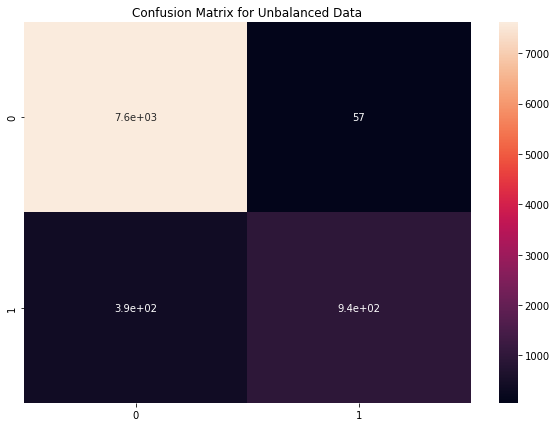

In [ ]:
plt.figure(figsize=(10,7))

sns.heatmap(confusion_matrix(y_pred, y_init), annot=True) # font size
plt.title("Confusion Matrix for Unbalanced Data")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report for Unbalanced Data : \n")
print(classification_report(y_pred, y_init))

Classification Report for Unbalanced Data : 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7671
           1       0.94      0.71      0.81      1329

    accuracy                           0.95      9000
   macro avg       0.95      0.85      0.89      9000
weighted avg       0.95      0.95      0.95      9000



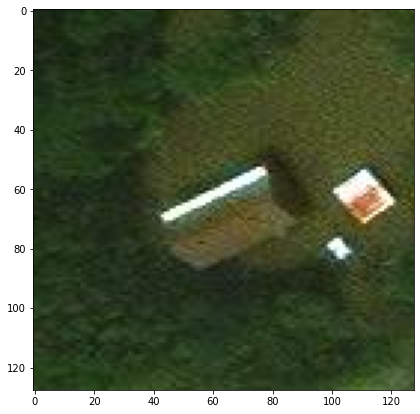

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/archive/test/damage/-93.548123_30.900623.jpeg')
fig = plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Damaged")
plt.show()

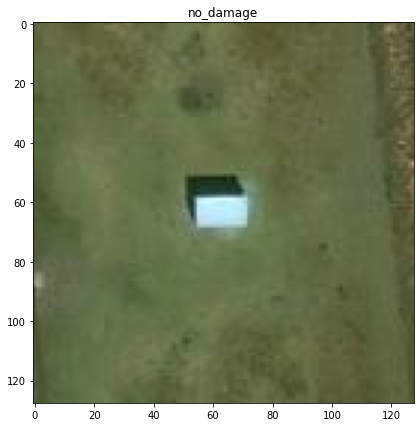

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/archive/test/no_damage/-95.061894_30.007746.jpeg')
fig = plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("no_damage")
plt.show()